# Geopandas

In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString

caricamento dati

In [2]:
countries = geopandas.read_file("data/ne_110m_admin_0_countries.zip")



Stampa  tabella

In [3]:
print(countries.head())





  iso_a3                  name      continent     pop_est  gdp_md_est  \
0    AFG           Afghanistan           Asia  34124811.0     64080.0   
1    AGO                Angola         Africa  29310273.0    189000.0   
2    ALB               Albania         Europe   3047987.0     33900.0   
3    ARE  United Arab Emirates           Asia   6072475.0    667200.0   
4    ARG             Argentina  South America  44293293.0    879400.0   

                                            geometry  
0  POLYGON ((61.21082 35.65007, 62.23065 35.27066...  
1  MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -...  
2  POLYGON ((21.02004 40.84273, 20.99999 40.58000...  
3  POLYGON ((51.57952 24.24550, 51.75744 24.29407...  
4  MULTIPOLYGON (((-66.95992 -54.89681, -67.56244...  


Nomi colonne

In [4]:
print(countries.columns)

Index(['iso_a3', 'name', 'continent', 'pop_est', 'gdp_md_est', 'geometry'], dtype='object')


Stampa nazioni

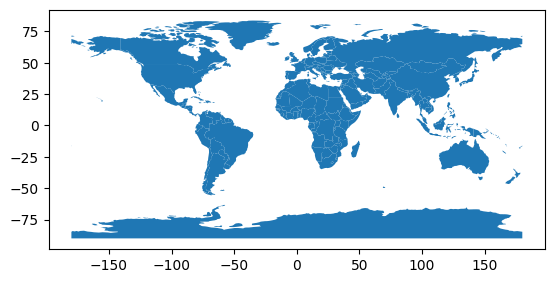

In [5]:
countries.plot()
plt.show()

Operazioni con cose geometriche

In [6]:
p = Point(0, 0)
print(p)
polygon = Polygon([(1, 1), (2,2), (2, 1)])
print(polygon.area)
print(polygon.distance(p))#%%

POINT (0 0)
0.5
1.4142135623730951


## Merging different data sources

In [7]:
cities = geopandas.read_file("data/ne_110m_populated_places.zip")
rivers = geopandas.read_file("data/ne_50m_rivers_lake_centerlines.zip")

[(-20.0, 60.0), (-40.0, 40.0)]

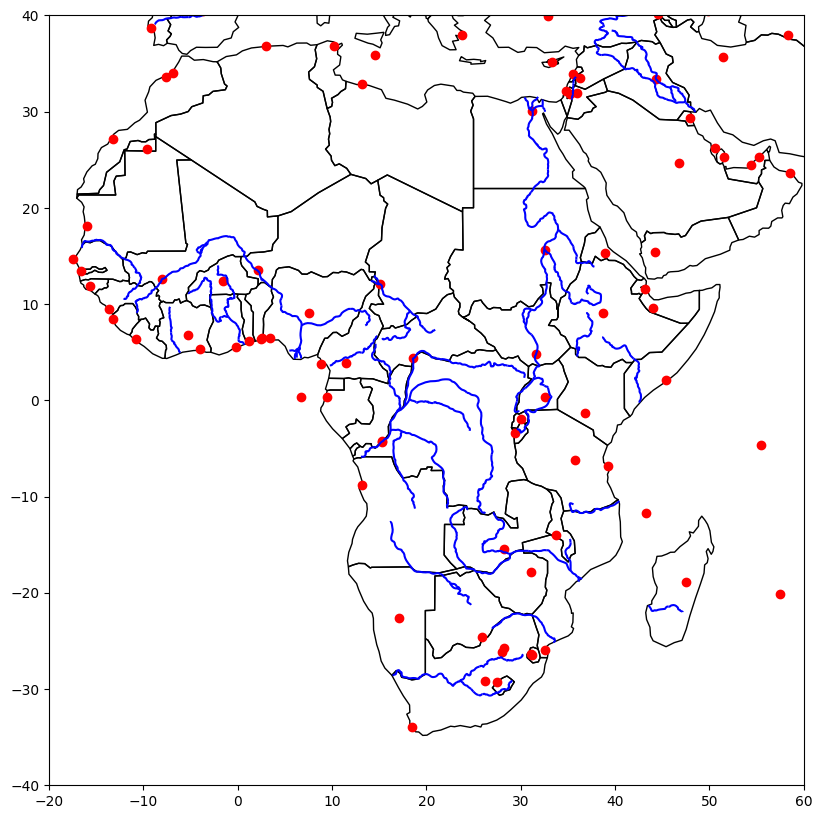

In [8]:
# fig, ax = plt.subplots(figsize=(15, 10))
ax = countries.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
rivers.plot(ax=ax,color='blue')
cities.plot(ax=ax, color='red')
ax.set(xlim=(-20, 60), ylim=(-40, 40))

## In Python coordinates are defined as (lon, lat) and not as (lat, lon) such as in other systems (i.e. Google Maps).

In [9]:
print(countries.crs)

EPSG:4326


In [10]:
# remove Antartica, as the Mercator projection cannot deal with the poles
countries = countries[(countries['name'] != "Antarctica")]
countries_mercator = countries.to_crs(epsg=3395) # or .to_crs("EPSG:3395")

Difference between two geometries

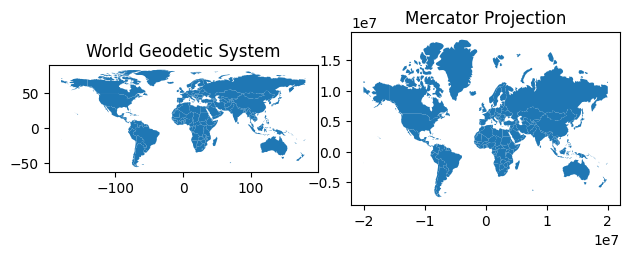

In [11]:
fig, axs = plt.subplots(1, 2)
countries.plot(ax=axs[0])
axs[0].set_title('World Geodetic System')
countries_mercator.plot(ax=axs[1])
axs[1].set_title('Mercator Projection')
plt.tight_layout()
plt.show()

# Parte 2

Qui, countries è un DataFrame che probabilmente contiene informazioni su diversi paesi, inclusi i loro nomi e dati geometrici (come poligoni che rappresentano i loro confini). La funzione .loc[] è usata per selezionare la geometria del Belgio.
countries['SOVEREIGNT'] == 'Belgium' filtra le righe dove la colonna 'name' è uguale a 'Belgium'.
'geometry' specifica che vogliamo ottenere i dati dalla colonna 'geometry'.
.item() è usato per estrarre il valore singolo dall'oggetto selezionato, che è tipicamente un oggetto geometrico (come un poligono).


In [12]:
belgium = countries.loc[countries['name'] == 'Belgium', 'geometry'].item()
paris = cities.loc[cities['name'] == 'Paris', 'geometry'].item()
brussels = cities.loc[cities['name'] == 'Brussels', 'geometry'].item()

# Converti il risultato booleano in stringa per la concatenazione
print('Brussel è in Belgio? ' + str(brussels.within(belgium))) # True
print('Belgio contiene Parigi? ' + str(belgium.contains(paris))) # True


Brussel è in Belgio? True
Belgio contiene Parigi? False


These can also be applied on GeoDataFrames:

Utilizzo di Una Libreria Esterna
Come menzionato precedentemente, potresti utilizzare una libreria come pycountry_convert per ottenere il continente basato sul nome del paese. Qui è un esempio di come potresti procedere se decidi di usare il nome del paese dalla colonna SOVEREIGNT:

In [13]:
import pycountry_convert as pc

def get_continent(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return "Unknown"  # Per gestire i casi in cui il nome del paese non è standard o la conversione fallisce



Esempio di utilizzo con i fiumi

<Axes: >

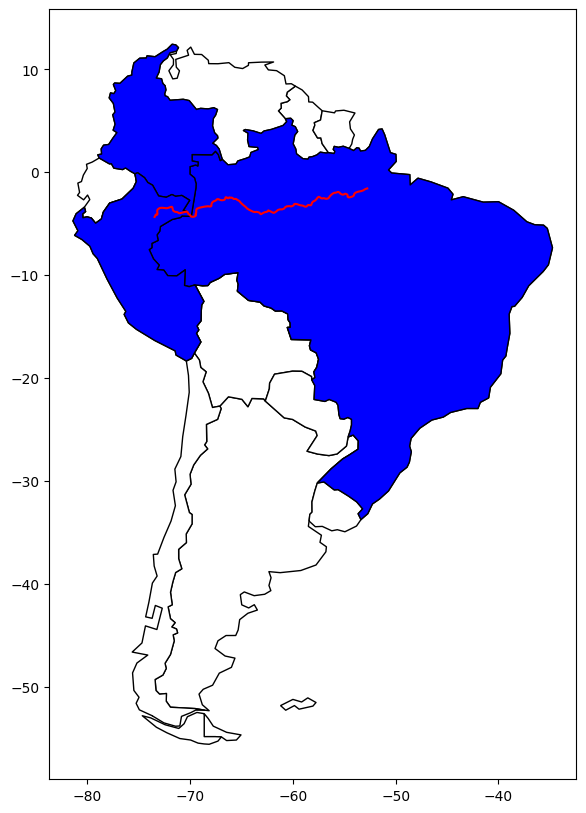

In [14]:
amazon = rivers[rivers['name'] == 'Amazonas']
amazon_countries = countries[countries.crosses(amazon.geometry.item())] # or .intersects
south_america = countries[countries['continent']=="South America"]
ax = south_america.plot(edgecolor='k', facecolor='white', figsize=(15, 10))
amazon_countries.plot(edgecolor='k', facecolor='blue', ax=ax)
amazon.plot(color='red', ax=ax)

south_america.plot() genera una mappa dei paesi sudamericani, colorandoli di bianco con bordi neri.
amazon_countries.plot() aggiunge i paesi attraversati dall'Amazonas alla mappa esistente, colorandoli di blu.
amazon.plot() traccia il fiume Amazonas in rosso sulla mappa.

Plot di Brussels

<Axes: >

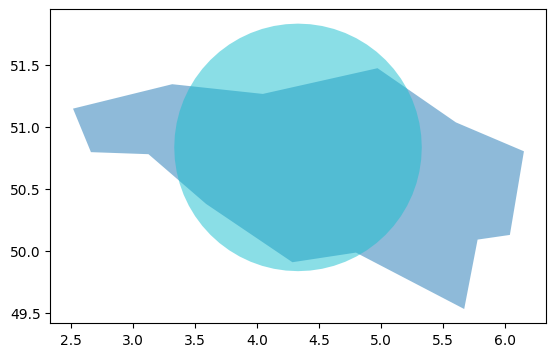

In [15]:
geopandas.GeoSeries([belgium, brussels.buffer(1)]).plot(alpha=0.5, cmap='tab10')

Questo codice è utile per visualizzare le relazioni spaziali e le sovrapposizioni tra diverse entità geografiche in modo intuitivo. Nell'esempio specifico, il plot generato mostrerà la posizione geografica del Belgio insieme a una zona tampone attorno a Bruxelles, permettendo di visualizzare quanto estesa è questa zona rispetto al paese. Questa tecnica è frequentemente usata in analisi geografiche per rappresentare zone d'influenza, aree di sicurezza, distanze di evacuazione, ecc

brussels.buffer(1): Questo metodo crea una geometria che rappresenta un'area (buffer) intorno a Bruxelles. L'area del buffer è definita con un raggio di "1" (l'unità dipende dal sistema di coordinate utilizzato, ad esempio metri, chilometri, gradi, ecc.).

.difference(belgium): Questo metodo calcola la differenza geometrica tra il buffer creato intorno a Bruxelles e la geometria del Belgio. Il risultato è una nuova geometria che rappresenta la parte del buffer di Bruxelles che non si sovrappone con il territorio del Belgio. In altre parole, mostra quali parti del buffer cadono fuori dai confini belgi.

<Axes: >

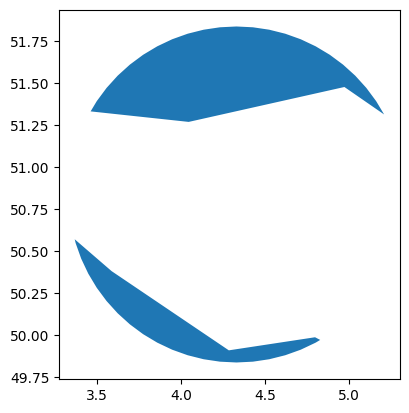

In [16]:
geopandas.GeoSeries([brussels.buffer(1).difference(belgium)]).plot()

Or, just like spatial relationships, they can be applied on a GeoDataFrame and a geometry. Let us for instance consider the African continent and a spatial bounding box:

<Axes: >

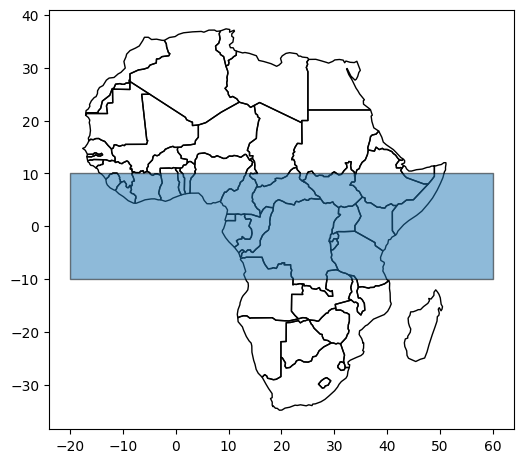

In [17]:
africa = countries[countries.continent == 'Africa']
box = LineString([(-10, 0), (50, 0)]).buffer(10, cap_style=3)
fig, ax = plt.subplots(figsize=(6, 6))
africa.plot(ax=ax, facecolor='none', edgecolor='k')
geopandas.GeoSeries([box]).plot(ax=ax, facecolor='C0', edgecolor='k', alpha=0.5)

In [18]:
africa_intersection = africa.intersection(box)
africa_intersection.head()

1     MULTIPOLYGON (((13.12099 -9.76690, 12.87537 -9...
11    POLYGON ((29.27638 -3.29391, 29.02493 -2.83926...
13    POLYGON ((1.86524 6.14216, 1.61895 6.83204, 1....
14    POLYGON ((-2.82750 9.64246, -3.51190 9.90033, ...
25                                        POLYGON EMPTY
dtype: geometry

Prendi solo quelle che sono attraversate dal box (quelle che non sono vuote)

<Axes: >

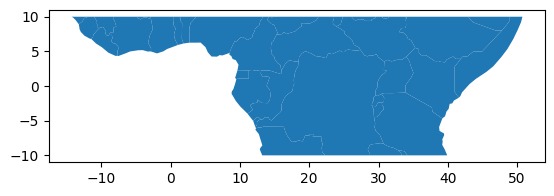

In [19]:
# remove the empty polygons before plotting
africa_intersection = africa_intersection[~africa_intersection.is_empty]
# plot the intersection
africa_intersection.plot()

## Unary Union
L'attributo unary_union viene utilizzato per combinare più oggetti geometrici in un'unica geometria. Questo è particolarmente utile quando si desidera unire tutte le geometrie individuali in un GeoDataFrame in una singola geometria sovrastante, che rappresenta l'unione di tutti gli elementi individuali.

<Axes: >

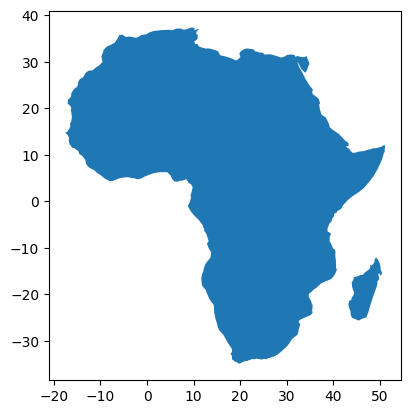

In [20]:

africa_union = africa.unary_union
geopandas.GeoSeries([africa_union]).plot()


'africa.unary_union' prende tutte le geometrie nel GeoDataFrame africa (che presumibilmente contiene le geometrie di tutti i paesi dell'Africa) e le fonde in una singola geometria. Questa singola geometria rappresenta l'intero continente come una forma continua senza confini interni.

'geopandas.GeoSeries([africa_union]).plot()' crea una GeoSeries con questa geometria unificata e la visualizza. Il grafico rappresenta visivamente l'Africa come una singola entità, illustrando l'area totale coperta da tutti i suoi paesi combinati senza mostrare i confini individuali.

## Dissolve
Il metodo dissolve in GeoPandas è un'operazione avanzata che aggrega le geometrie in base a una colonna specificata. È simile a una combinazione di groupby (usato in pandas per raggruppare i dati) e unary_union (usato in GeoPandas per unire le geometrie).

In [21]:
continents = countries.dissolve(by="continent")
print(continents)


                                                                  geometry  \
continent                                                                    
Africa                   MULTIPOLYGON (((-11.43878 6.78592, -11.70819 6...   
Asia                     MULTIPOLYGON (((48.67923 14.00320, 48.23895 13...   
Europe                   MULTIPOLYGON (((-53.55484 2.33490, -53.77852 2...   
North America            MULTIPOLYGON (((-156.02368 19.81422, -155.8500...   
Oceania                  MULTIPOLYGON (((148.28907 -40.87544, 148.35986...   
Seven seas (open ocean)  POLYGON ((68.93500 -48.62500, 69.58000 -48.940...   
South America            MULTIPOLYGON (((-68.63999 -55.58002, -69.23210...   

                        iso_a3                    name     pop_est  gdp_md_est  
continent                                                                       
Africa                     AGO                  Angola  29310273.0    189000.0  
Asia                       AFG             Afghanistan

countries.dissolve(by="continent") raggruppa il GeoDataFrame countries per la colonna "continent", quindi applica un'unione spaziale a tutte le geometrie all'interno di ogni gruppo. Ciò significa che tutti i paesi di ciascun continente sono fusi in una singola geometria per continente.

Il risultato, continents, è un nuovo GeoDataFrame in cui ogni riga rappresenta un continente con i suoi dati associati e una nuova geometria che è l'unione di tutte le geometrie dei paesi all'interno di quel continente.

print(continents) visualizzerà il nuovo GeoDataFrame. Tipicamente, questo GeoDataFrame avrà meno righe dell'originale (una per continente) e includerà dati geometrici aggregati che rappresentano ciascun intero continente.


# Esercizio 1

Prendo i dati

In [22]:
districts = geopandas.read_file("data/paris_districts.geojson").to_crs(epsg=2154)
stations = geopandas.read_file("data/paris_bike_stations.geojson").to_crs(epsg=2154)

Create a Shapely point object with the coordinates of the Eiffel Tower and assign it to a variable called
eiffel\_tower. Print the result

In [23]:
eiffel_tower = Point(255422.6, 6250868.9)
print(eiffel_tower)

POINT (255422.6 6250868.9)


• Check if the Eiffel Tower is located within the Montparnasse district.

In [24]:
district_montparnasse = districts.loc[52, 'geometry']
print('District Montparnasse contains Eiffel Tower: ' + str(district_montparnasse.contains(eiffel_tower)))

District Montparnasse contains Eiffel Tower: False


• Check if the Montparnasse district contains the following bike station location.

In [25]:
bike_station = stations.loc[293, 'geometry']
print('District Montparnasse contains bike station: ' + str(district_montparnasse.contains(bike_station)))

District Montparnasse contains bike station: True


Calculate the distance between the Eiffel Tower and the bike station (note: in this case, the distance is returned in meters).

In [26]:
distance_eiffelTower_bikeStation= eiffel_tower.distance(bike_station)
print('the distance between the Eiffel Tower and the bike station is: ' + str(distance_eiffelTower_bikeStation) + ' meters')

the distance between the Eiffel Tower and the bike station is: 725909.5264768474 meters


• In which district is the Eiffel Tower located ?

In [27]:
print(districts.columns)

Index(['id', 'district_name', 'population', 'geometry'], dtype='object')


In [28]:
isIn= False
for i, dis in districts.iterrows():
    if dis['geometry'].contains(eiffel_tower):
        isIn= True
    print('Eiffel Tower is in ' + dis['district_name']+ '? ' + str(isIn))
        

Eiffel Tower is in St-Germain-l'Auxerrois? False
Eiffel Tower is in Halles? False
Eiffel Tower is in Palais-Royal? False
Eiffel Tower is in Place-Vendôme? False
Eiffel Tower is in Gaillon? False
Eiffel Tower is in Vivienne? False
Eiffel Tower is in Mail? False
Eiffel Tower is in Bonne-Nouvelle? False
Eiffel Tower is in Arts-et-Metiers? False
Eiffel Tower is in Enfants-Rouges? False
Eiffel Tower is in Archives? False
Eiffel Tower is in Sainte-Avoie? False
Eiffel Tower is in Saint-Merri? False
Eiffel Tower is in Saint-Gervais? False
Eiffel Tower is in Arsenal? False
Eiffel Tower is in Notre-Dame? False
Eiffel Tower is in Saint-Victor? False
Eiffel Tower is in Jardin-des-Plantes? False
Eiffel Tower is in Val-de-Grace? False
Eiffel Tower is in Sorbonne? False
Eiffel Tower is in Monnaie? False
Eiffel Tower is in Odeon? False
Eiffel Tower is in Notre-Dame-des-Champs? False
Eiffel Tower is in Saint-Germain-des-Prés? False
Eiffel Tower is in Saint-Thomas-d'Aquin? False
Eiffel Tower is in Inval

# Exercise 2: Exploring a Land Use dataset
For the following exercises, we first introduce a new dataset: a dataset about the land use of Paris (a simplified
version based on the open European Urban Atlas). The land use indicates for what kind of activity a certain
area is used, such as residential area or for recreation. It is a polygon dataset, with a label representing the
land use class for different areas in Paris.
In this exercise, we will read the data, explore it visually, and calculate the total area of the different classes of
land use in the area of Paris

• Read in the ’paris_land_use.shp’ file and assign the result to a variable land_use.

In [29]:
land_use = geopandas.read_file("data/paris_land_use.zip")

Make a plot of land_use, using the ’class’ column to color the polygons. Add a legend with legend=True,
and make the figure size a bit larger.

<Axes: >

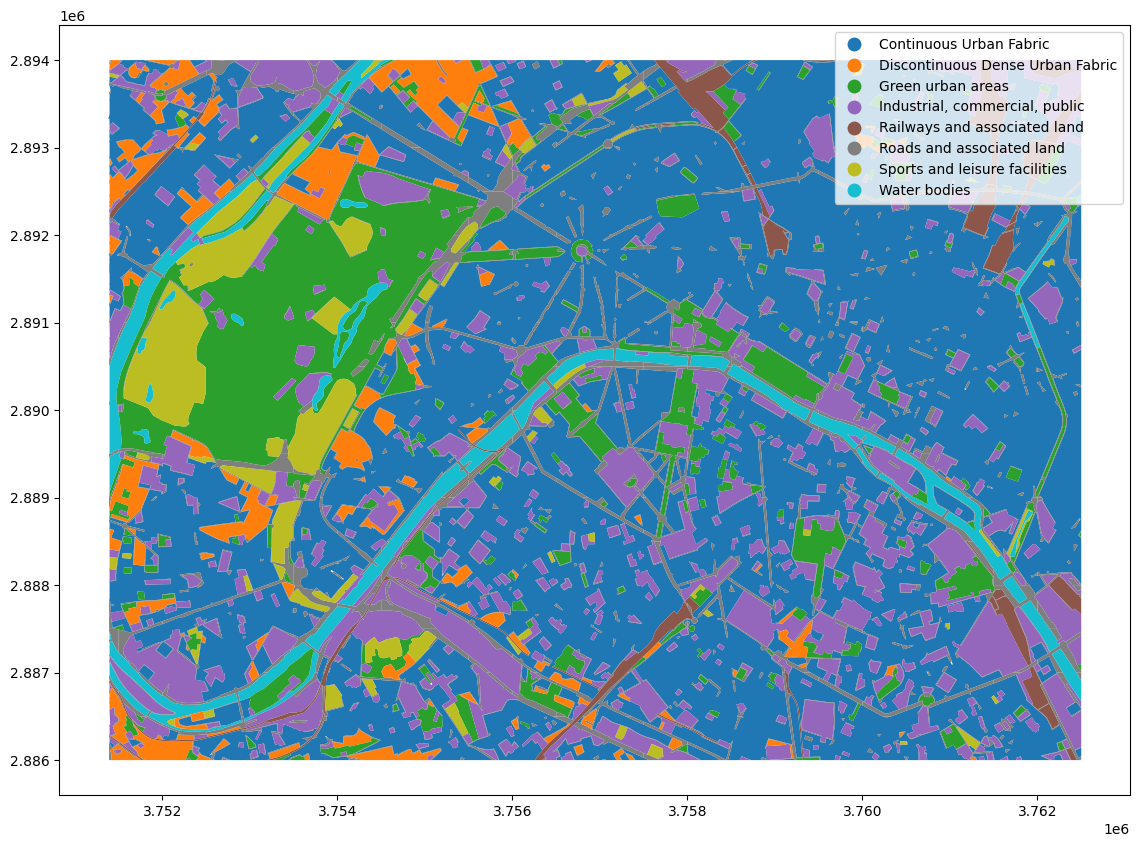

In [30]:
land_use.plot(column='class', legend=True, figsize=(15, 10))

• Add a new column ’area’ to the dataframe with the area of each polygon.

In [31]:
area = land_use.area
land_use['area'] = area

Calculate the total area in km2 for each ’class’ using the groupby() method, and print the result

In [32]:
total_area_metri_quadrati = land_use.groupby('class')['area'].sum()
total_area_metri_quadrati_km2 = total_area_metri_quadrati / 10**6
print(total_area_metri_quadrati_km2)

class
Continuous Urban Fabric             45.943090
Discontinuous Dense Urban Fabric     3.657343
Green urban areas                    9.858438
Industrial, commercial, public      13.295042
Railways and associated land         1.935793
Roads and associated land            7.401574
Sports and leisure facilities        3.578509
Water bodies                         3.189706
Name: area, dtype: float64


groupby('class') raggruppa il DataFrame per la colonna class. Questo implica che ogni valore unico nella colonna class forma un gruppo.

['area'] seleziona la colonna area di questi gruppi. Quindi, l'operazione viene applicata solo ai dati della colonna area.

.sum() calcola la somma degli elementi della colonna area per ciascun gruppo. Ciò restituisce un nuovo oggetto (tipicamente una Series di pandas) dove ogni indice è un valore unico di class e ogni valore è la somma totale dell'area per quella classe.

# EXERCISE 3: Intersection of two polygons

For this exercise, we are going to use 2 individual polygons: the district of Muette extracted from the districts dataset, and the green urban area of Boulogne, a large public park in the west of Paris, extracted from the land_use dataset. The two polygons have already been assigned to the muette and park_boulogne variables. We first visualize the two polygons

In [33]:
# bisogna convertire i valori in un sistema di coordinate comune
land= land_use.to_crs(epsg=2154)
park_boulogne = land[land['class'] == "Green urban areas"].sort_values('area').geometry.iloc[-1]
muette = districts[districts.district_name == 'Muette'].geometry.item()

land_use[land_use['class'] == "Green urban areas"]: Questo frammento filtra il DataFrame land_use per selezionare solo le righe dove la colonna class è uguale a "Green urban areas". Si presume che class sia una colonna che descrive il tipo di uso del suolo, e "Green urban areas" si riferisca a zone urbane verdi come parchi o giardini.
.sort_values('area'): Dopo aver filtrato per classe, questo comando ordina le righe risultanti per la colonna area, presumibilmente contenente la misura dell'area di ciascun segmento di terreno. L'ordinamento è in ordine crescente per default.
.geometry: Questo accessor seleziona la colonna geometry del DataFrame risultante, che contiene le geometrie (forme geospaziali) delle aree verdi urbane.
.iloc[-1]: Infine, .iloc[-1] seleziona l'ultima geometria nella serie ordinata, che corrisponde all'area verde urbana più grande (dato che i valori sono ordinati in modo crescente per area).

districts[districts.district_name == 'Muette']: Questo frammento filtra il DataFrame districts per selezionare le righe dove la colonna district_name è uguale a "Muette". "Muette" è presumibilmente il nome di un distretto.
.geometry: Questo accessor seleziona la colonna geometry del DataFrame filtrato, che contiene la geometria del distretto di Muette.
.item(): Il metodo .item() viene usato per estrarre l'elemento dalla serie se la serie contiene un solo elemento. Questo è tipico quando ci si aspetta un solo risultato dalla query, come nel caso di un distretto specifico

In [34]:
print(park_boulogne)
print(muette)



POLYGON ((643236.0285250762 6861691.892181491, 643236.6312126094 6861691.857681814, 643237.4962653887 6861742.008689355, 643202.0275054724 6861724.893489458, 643161.0702811356 6861721.460360108, 643147.9466949205 6861777.2637725305, 643143.9273887111 6861910.910710645, 643172.9696491212 6862097.500212687, 643276.0602285465 6862429.675556197, 643374.0484106212 6862710.221356212, 643389.07875926 6862753.254229153, 643391.4551665566 6862772.322888601, 643400.9527792507 6862848.53337777, 643430.0198343782 6862968.961020596, 643468.3561721443 6863072.189646112, 643468.356544761 6863072.190481583, 643532.4817383477 6863214.464287462, 643531.9192581893 6863214.709485219, 643537.4525459392 6863227.116119711, 643561.7282009253 6863216.863608339, 643565.036240207 6863244.550908302, 643604.5582155399 6863326.306852826, 643679.65829576 6863410.342667198, 643697.6829048505 6863379.022377142, 643698.4751244714 6863377.645781825, 643698.475125227 6863377.645782056, 643698.4751352791 6863377.645764588

• Plot the two polygons in a single map to examine visually the degree of overlap.

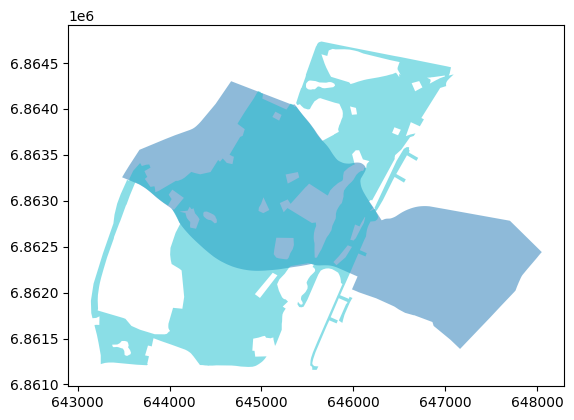

In [35]:
ax = geopandas.GeoSeries([muette, park_boulogne]).plot(alpha=0.5, cmap='tab10')
plt.show()


• Calculate the intersection of the park_boulogne and muette polygons and plot it

<Axes: >

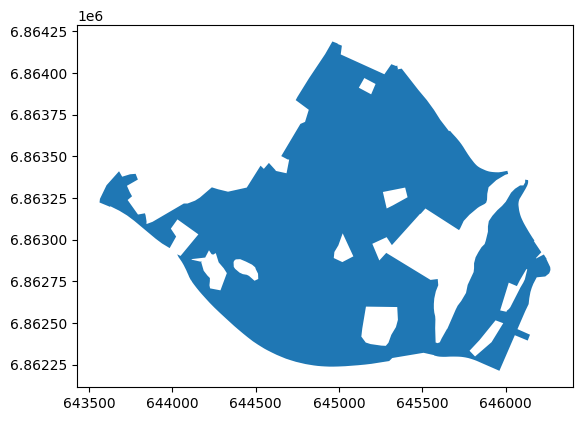

In [36]:
intersection = muette.intersection(park_boulogne)
geopandas.GeoSeries([intersection]).plot()

• Print the proportion of the area of the district that is occupied by the park.

In [37]:
proportion = intersection.area / muette.area
print('The proportion of the area of the district that is occupied by the park is: ' + str(proportion))

The proportion of the area of the district that is occupied by the park is: 0.4352093960815872


# Link utili:
GeoDataFrames : https://github.com/jorisvandenbossche/geopandas-

GeoDataFrames to moving objects: https://github.com/movingpandas/movingpandas
